# Анализ открытых данных по г. Санкт-Петебургу

##### Источники:  https://data.gov.spb.ru/ - портал "Открытые данные Санкт-Петербурга", Википедия

In [1]:
import pandas as pd

In [2]:
def prepare_data(value):
    result = ''
    if isinstance(value, str):
         result = value.strip().replace(' район', '')
    else:
        result = value
    
    return result

#### Территория

In [3]:
df_adm_head = (
    pd.read_csv("./data/Административно-территориальное деление/Административно-территориальное деление.csv",
                usecols=['name'],
               )
    )
df_adm_head.rename(columns={'name': 'district'}, inplace=True)
df_adm_head['district'] = df_adm_head.district.apply(prepare_data)
#df_adm_head
df_adm_stat = (
    pd.read_csv("./data/Административно-территориальное деление/Население и площадь.csv",
                dtype={'population': int, 'area': float}
               )
    )
df_adm_stat['district'] = df_adm_stat.district.apply(prepare_data)
df_adm = df_adm_head.merge(df_adm_stat, how='left', left_on='district', right_on='district')
#df_adm.head()

In [4]:
df_adm_prom = (
    pd.read_csv("./data/Административно-территориальное деление/Промзоны.csv",
                usecols=['name', 'district', 'area'],
                dtype={'area': float}
               )
    )
df_adm_prom['area'] = df_adm_prom['area'] * .01 # гектары в квадратные километры
df_adm_prom = df_adm_prom.groupby('district').sum().reset_index()

In [5]:
df_adm_metro = pd.read_csv("./data/Дороги и транспорт/Метро.csv")
df_adm_metro = df_adm_metro.groupby('district').count().reset_index()

In [6]:
# подключаем данные по количеству зеленых насаждений городского значения
df_green_1 = pd.read_csv("./data/Прочее/Зеленые насаждения общего пользования городского значения.csv"
                         , usecols=['district', 'reference_area_hectare']
                         , decimal=","
                        )
df_green_1 = df_green_1.groupby(['district']).sum().reset_index()
df_green_1['area'] = df_green_1['reference_area_hectare'] * .01 # гектары в квадратные километры
df_green_1.drop('reference_area_hectare', axis=1, inplace=True)

# подключаем сюда зеленые насаждения местного значения
df_green_2 = pd.read_csv("./data/Прочее/Зеленые насаждения общего пользования местного значения.csv"
                         , usecols=['district', 'reference_area_hectare']
                        )
df_green_2 = df_green_2.groupby(['district']).sum().reset_index()
df_green_2['area'] = df_green_2['reference_area_hectare'] * .01 # гектары в квадратные километры
df_green_2.drop('reference_area_hectare', axis=1, inplace=True)

# получаем общую площадь зелёных насаждений
df_green_total = df_green_1.merge(df_green_2, how='outer', left_on='district', right_on='district').fillna(0)
df_green_total['area'] = df_green_total['area_x'] + df_green_total['area_y']
df_green_total.drop(['area_x', 'area_y'], axis=1, inplace=True)
#df_green_total

In [7]:
# подключаем данные по установленным видеокамерам и терминалам
df_video = pd.read_csv("./data/Информационные технологии/Адреса установки видеокамер.csv"
                         , usecols=['district', 'amount']
                        )
df_video = df_video.groupby(['district']).sum().reset_index()

df_terminal = pd.read_csv("./data/Информационные технологии/Адреса установки терминалов Гражданин-Полиция.csv"
                         , usecols=['district', 'amount']
                        )
df_terminal = df_terminal.groupby(['district']).sum().reset_index()

In [8]:
# сливаем все данные в первую таблицу для анализа:

# население и площади
df_1 = df_adm.merge(df_adm_prom, left_on='district', right_on='district', how='left')
#df_1.drop('district', axis=1, inplace=True)
df_1.fillna(0, inplace=True)
df_1.rename(columns={'area_x': 'total_area', 'area_y': 'prom_area'}, inplace=True)

# зелёные насаждения
df_1 = df_1.merge(df_green_total, left_on='district', right_on='district', how='left')
#df_1.drop('district', axis=1, inplace=True)
df_1.fillna(0, inplace=True)
df_1.rename(columns={'area': 'green_area'}, inplace=True)

# безопасность:
df_1 = df_1.merge(df_video, left_on='district', right_on='district', how='left')
#df_1.drop('district', axis=1, inplace=True)
df_1.fillna(0, inplace=True)
df_1.rename(columns={'amount': 'vcam_count'}, inplace=True)

df_1 = df_1.merge(df_terminal, left_on='district', right_on='district', how='left')
#df_1.drop('district', axis=1, inplace=True)
df_1.fillna(0, inplace=True)
df_1.rename(columns={'amount': 'term_count'}, inplace=True)


# метро
df_1 = df_1.merge(df_adm_metro, left_on='district', right_on='district', how='left')
#df_1.drop('district', axis=1, inplace=True)
df_1.fillna(0, inplace=True)
df_1.rename(columns={'name': 'metro_count'}, inplace=True)

df_1.metro_count = df_1.metro_count.astype(int)
df_1.term_count = df_1.term_count.astype(int)
df_1

,district,population,total_area,prom_area,green_area,vcam_count,term_count,metro_count
0,Центральный,220217,17.77,0.0000,0.931408,866,3,11
1,Адмиралтейский,163785,13.82,0.0000,1.086506,784,2,9
2,Выборгский,502988,115.52,7.9430,7.590716,3433,4,6
3,Красносельский,369766,90.49,20.6730,5.944252,769,32,0
4,Василеостровский,209188,16.70,0.0000,1.397288,644,0,2
5,Фрунзенский,406029,37.52,5.5150,3.995350,2807,0,4
6,Московский,343935,73.07,4.8540,4.359597,1097,15,6
7,Петродворцовый,138146,107.08,8.6319,11.452358,384,0,0
8,Калининский,535428,40.18,0.0000,5.601719,4978,0,5
9,Пушкинский,193180,240.09,20.0480,6.605971,271,1,0


#### Медицина

In [9]:
# собираем вторую таблицу для анализа (медицинские организации)
df_med = pd.read_csv("./data/Здравоохранение/Лечебно-профилактические учреждения.csv", usecols=['name', 'type', 'district'])

df_med['child_polyclinic'] = df_med[ df_med['type'] == 'Детские поликлиники']['name']
df_med['child_hospital'] = df_med[ df_med['type'] == 'Детские городские больницы (кроме областных)']['name']
df_med['polyclinic'] = df_med[ df_med['type'] == 'Поликлиники']['name']
df_med['hospital'] = df_med[ df_med['type'] == 'Городские больницы (включая клинические)']['name']
df_med['ambulance'] = df_med[ df_med['type'] == 'Станции скорой медицинской помощи']['name']
df_med_group = df_med.groupby('district').count().reset_index()
df_med_group.drop(['name', 'type'], axis=1, inplace=True)

df_2 = df_adm.merge(df_med_group, left_on='district', right_on='district', how='left')
#df_2.drop('district', axis=1, inplace=True)
df_2.fillna(0, inplace=True)

df_2.rename(columns={'area': 'total_area'}, inplace=True)
df_2

,district,population,total_area,child_polyclinic,child_hospital,polyclinic,hospital,ambulance
0,Центральный,220217,17.77,2,1,4,1,1
1,Адмиралтейский,163785,13.82,0,1,4,2,0
2,Выборгский,502988,115.52,5,1,6,2,0
3,Красносельский,369766,90.49,0,1,3,1,0
4,Василеостровский,209188,16.70,0,1,2,1,0
5,Фрунзенский,406029,37.52,0,1,5,0,0
6,Московский,343935,73.07,1,0,4,2,0
7,Петродворцовый,138146,107.08,0,0,1,1,1
8,Калининский,535428,40.18,1,0,6,2,0
9,Пушкинский,193180,240.09,1,0,1,1,1


#### Культура

In [10]:
df_theatre = pd.read_csv("./data/Туризм и отдых/Театры.csv", usecols=['district', 'oid'])
df_theatre['district'] = df_theatre.district.apply(prepare_data)
df_theatre = df_theatre.groupby(['district']).count().reset_index()
df_theatre.rename(columns={'oid': 'theatre_count'}, inplace=True)
#df_theatre

df_museum = pd.read_csv("./data/Туризм и отдых/Музеи.csv", usecols=['district', 'oid'])
df_museum = df_museum[ df_museum.district.notnull() ] # пожертвуем данными, где не известен район
df_museum['district'] = df_museum.district.apply(prepare_data)
df_museum = df_museum.groupby(['district']).count().reset_index()
df_museum.rename(columns={'oid': 'museum_count'}, inplace=True)
#df_museum

df_landmarks = pd.read_csv("./data/Туризм и отдых/Достопримечательности.csv", usecols=['district', 'oid'])
df_landmarks = df_landmarks[ df_landmarks.district.notnull() ] # пожертвуем данными, где не известен район
df_landmarks.district = df_landmarks.district.apply(prepare_data)
df_landmarks = df_landmarks.groupby(['district']).count().reset_index()
df_landmarks.rename(columns={'oid': 'landmarks_count'}, inplace=True)
#df_landmarks

df_culture = pd.read_csv("./data/Культура/Объекты культурного наследия.csv", usecols=['district', 'number'])
df_culture.district = df_culture.district.apply(prepare_data)
df_culture = df_culture.groupby(['district']).count().reset_index()
df_culture.rename(columns={'number': 'cultural_heritage_site_count'}, inplace=True)
#df_culture

# сливаем всё в третью таблицу для анализа

df_3 = df_adm.merge(df_theatre, left_on='district', right_on='district', how='left')
df_3 = df_3.merge(df_museum, left_on='district', right_on='district', how='left')
df_3 = df_3.merge(df_landmarks, left_on='district', right_on='district', how='left')
df_3 = df_3.merge(df_culture, left_on='district', right_on='district', how='left')
df_3.fillna(0, inplace=True)
df_3['theatre_count'] = df_3.theatre_count.astype(int)
df_3['museum_count'] = df_3.museum_count.astype(int)
df_3

,district,population,area,theatre_count,museum_count,landmarks_count,cultural_heritage_site_count
0,Центральный,220217,17.77,32,62,117,1873
1,Адмиралтейский,163785,13.82,10,31,106,1027
2,Выборгский,502988,115.52,1,7,32,346
3,Красносельский,369766,90.49,0,0,8,113
4,Василеостровский,209188,16.70,3,25,33,795
5,Фрунзенский,406029,37.52,1,3,15,213
6,Московский,343935,73.07,2,6,13,328
7,Петродворцовый,138146,107.08,0,4,22,1052
8,Калининский,535428,40.18,0,5,18,269
9,Пушкинский,193180,240.09,0,7,34,926


#### Дошкольные и школьные образовательные учреждения

In [11]:
df_kindergarten = pd.read_csv("./data/Образование и наука/Перечень дошкольных образовательных организаций.csv"
                              , usecols=['district', 'name']
                              )
df_kindergarten['district'] = df_kindergarten.district.apply(prepare_data)
df_kindergarten['district'].fillna('Центральный', inplace=True)
df_kindergarten = df_kindergarten.groupby(['district']).count().reset_index()
df_kindergarten.rename(columns={'name': 'kindergarten_count'}, inplace=True)

df_school = pd.read_csv("./data/Образование и наука/Перечень образовательных организаций (школ, гимназий, лицеев).csv"
                              , usecols=['district', 'name']
                              )
df_school['district'] = df_school.district.apply(prepare_data)
df_school = df_school.groupby(['district']).count().reset_index()
df_school.rename(columns={'name': 'school_count'}, inplace=True)
#df_school

df_4 = df_adm.merge(df_kindergarten, left_on='district', right_on='district', how='left')
df_4 = df_4.merge(df_school, left_on='district', right_on='district', how='left')
df_4.fillna(0, inplace=True)
df_4['kindergarten_count'] = df_4.kindergarten_count.astype(int)
#df_4['museum_count'] = df_4.museum_count.astype(int)
df_4

,district,population,area,kindergarten_count,school_count
0,Центральный,220217,17.77,66,43
1,Адмиралтейский,163785,13.82,43,76
2,Выборгский,502988,115.52,72,66
3,Красносельский,369766,90.49,76,98
4,Василеостровский,209188,16.70,40,25
5,Фрунзенский,406029,37.52,92,56
6,Московский,343935,73.07,71,37
7,Петродворцовый,138146,107.08,30,19
8,Калининский,535428,40.18,100,114
9,Пушкинский,193180,240.09,45,64



#### Cоотношение зеленых насаждений и промышленных зон к общей площади

In [49]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

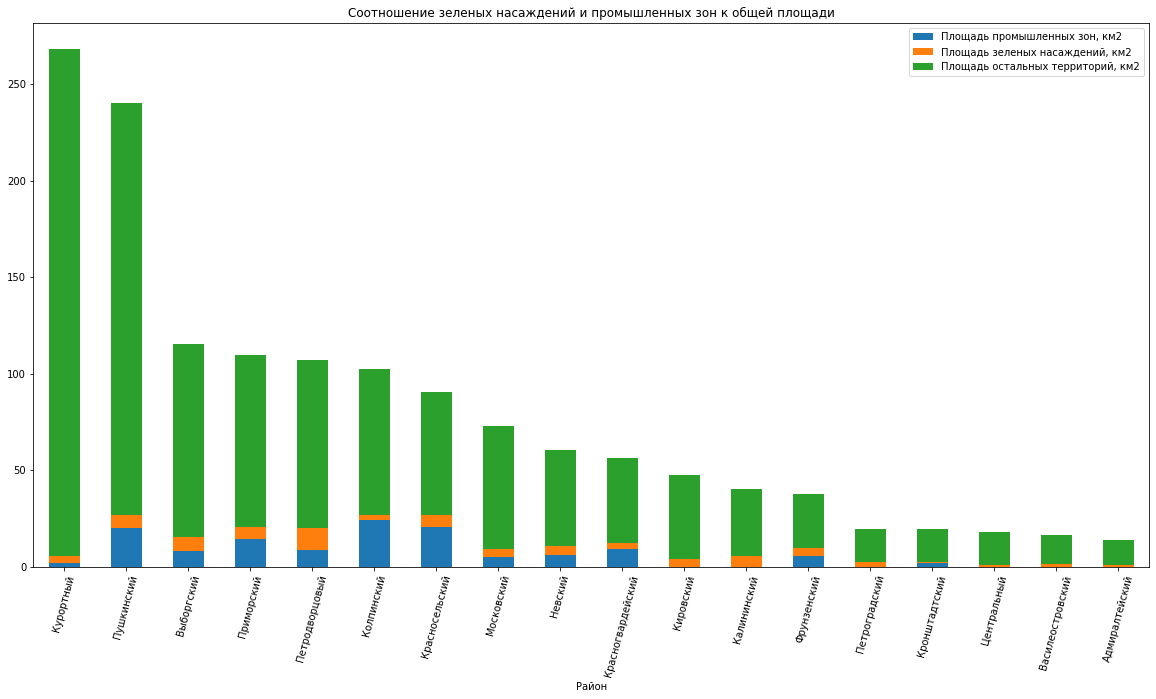

In [51]:
df_1_viz = df_1.set_index('district')
df_1_viz['delta'] = df_1_viz['total_area'] - df_1_viz['prom_area'] - df_1_viz['green_area']
df_1_viz = df_1_viz[['prom_area', 'green_area', 'delta']]
df_1_viz.sort_values(by='delta', ascending=False, inplace=True)

df_1_viz.index.name = 'Район'
df_1_viz.columns =['Площадь промышленных зон, км2', 'Площадь зеленых насаждений, км2', 'Площадь остальных территорий, км2']

df_1_viz.plot.bar(rot=75, stacked=True, title='Cоотношение зеленых насаждений и промышленных зон к общей площади')



#### Плотность населения по районам

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

Text(0.5, 1.0, 'Плотность населения районов Петербурга')

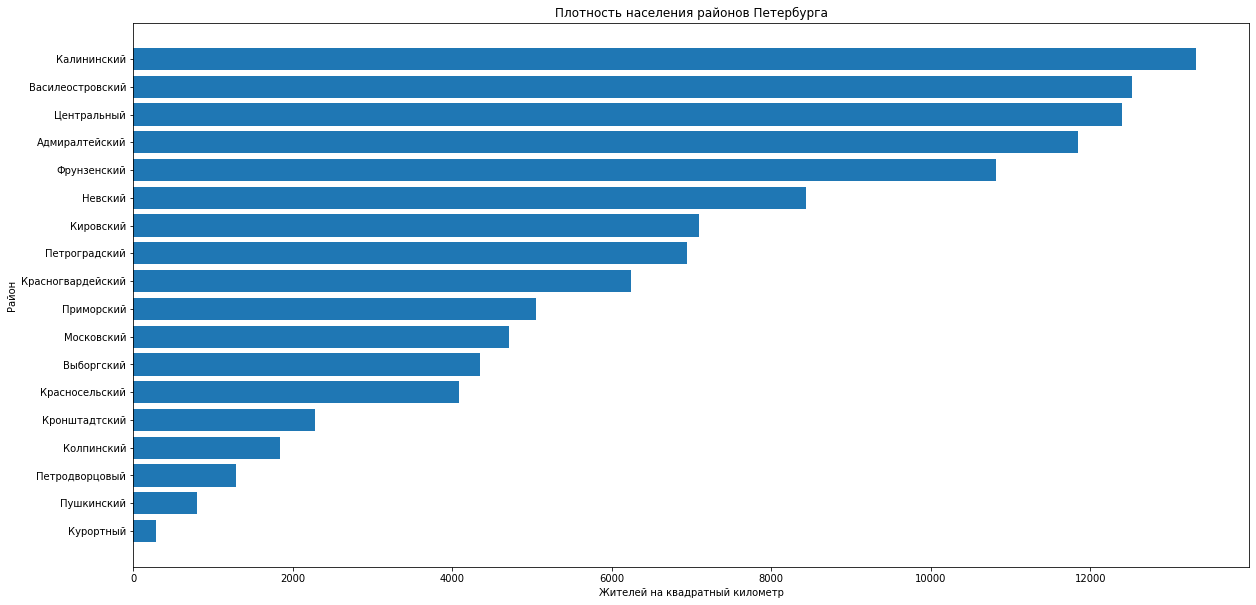

In [15]:
viz_2 = df_1
viz_2['density'] = viz_2['population'] / viz_2['total_area']
viz_2 = viz_2.sort_values(by='density')

plt.barh(viz_2['district'], viz_2['density'])
plt.xlabel('Жителей на квадратный километр')
plt.ylabel('Район')
plt.title('Плотность населения районов Петербурга')
#plt.text(20000, 0.5, 'Most common name')
#plt.text(25000, 1, 'dfhdfh')
#plt.grid()

#### Соотношение площади, населения и количества поликлиник

In [16]:
import seaborn as sns

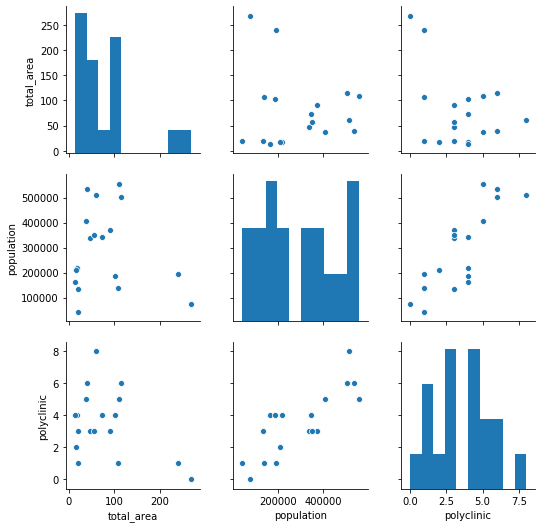

In [17]:
viz_3 = df_2

sns_plot = sns.pairplot(viz_3[['total_area', 'population', 'polyclinic']])
sns_plot
#viz_3

#### Количество объектов культурного наследия

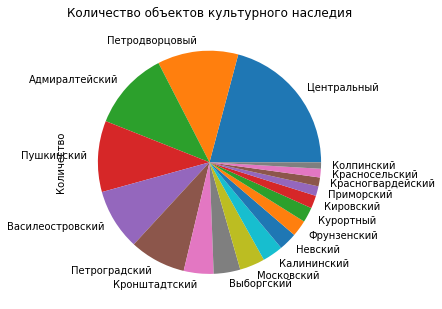

In [52]:
plt.rcParams['figure.figsize'] = [5, 10]
viz_4 = df_3.sort_values(by='cultural_heritage_site_count', ascending=False)
viz_4 = viz_4.set_index('district')
viz_4.rename(columns={'cultural_heritage_site_count': 'Количество'}, inplace=True)
viz_4.plot(kind='pie', y='Количество', title='Количество объектов культурного наследия', legend=False)

#### Соотношение количества школ и детских садов с количеством населения

In [98]:
import plotly.express as px

viz_5 = df_4[['district', 'population', 'kindergarten_count', 'school_count']]
viz_5 = viz_5.sort_values(by=['population'])
viz_5['population'] = viz_5['population'] / 1000
viz_5.rename(columns={'school_count': 'Количество школ', 'district': 'Район',
                      'kindergarten_count': 'Количество детских садов', 'population': 'Население, тыс.чел.'}, inplace=True)

df_melt = viz_5.melt(id_vars='Район', value_vars=['Количество детских садов', 'Количество школ', 'Население, тыс.чел.'])

px.line(df_melt, x='Район' , y='value' , color='variable')